---
title: "4. Manipulating Geospatial Data"
author: "kim dayeon"
date: today
categories: [news, code, analysis]
image: "4mani.png"
---

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium

from folium import Marker
import warnings 
warnings.filterwarnings('ignore')

# Introduction
* Geocoding
Geocoding is the process of converting the name of a place or an address to a location on a map. If you have ever looked up a geographic location based on a landmark description with Google Maps, Bing Maps, or Baidu Maps, for instance, then you have used a geocoder!



Geocoding
Geocoding is the process of converting the name of a place or an address to a location on a map. If you have ever looked up a geographic location based on a landmark description with Google Maps, Bing Maps, or Baidu Maps, for instance, then you have used a geocoder!



We'll use geopy to do all of our geocoding.

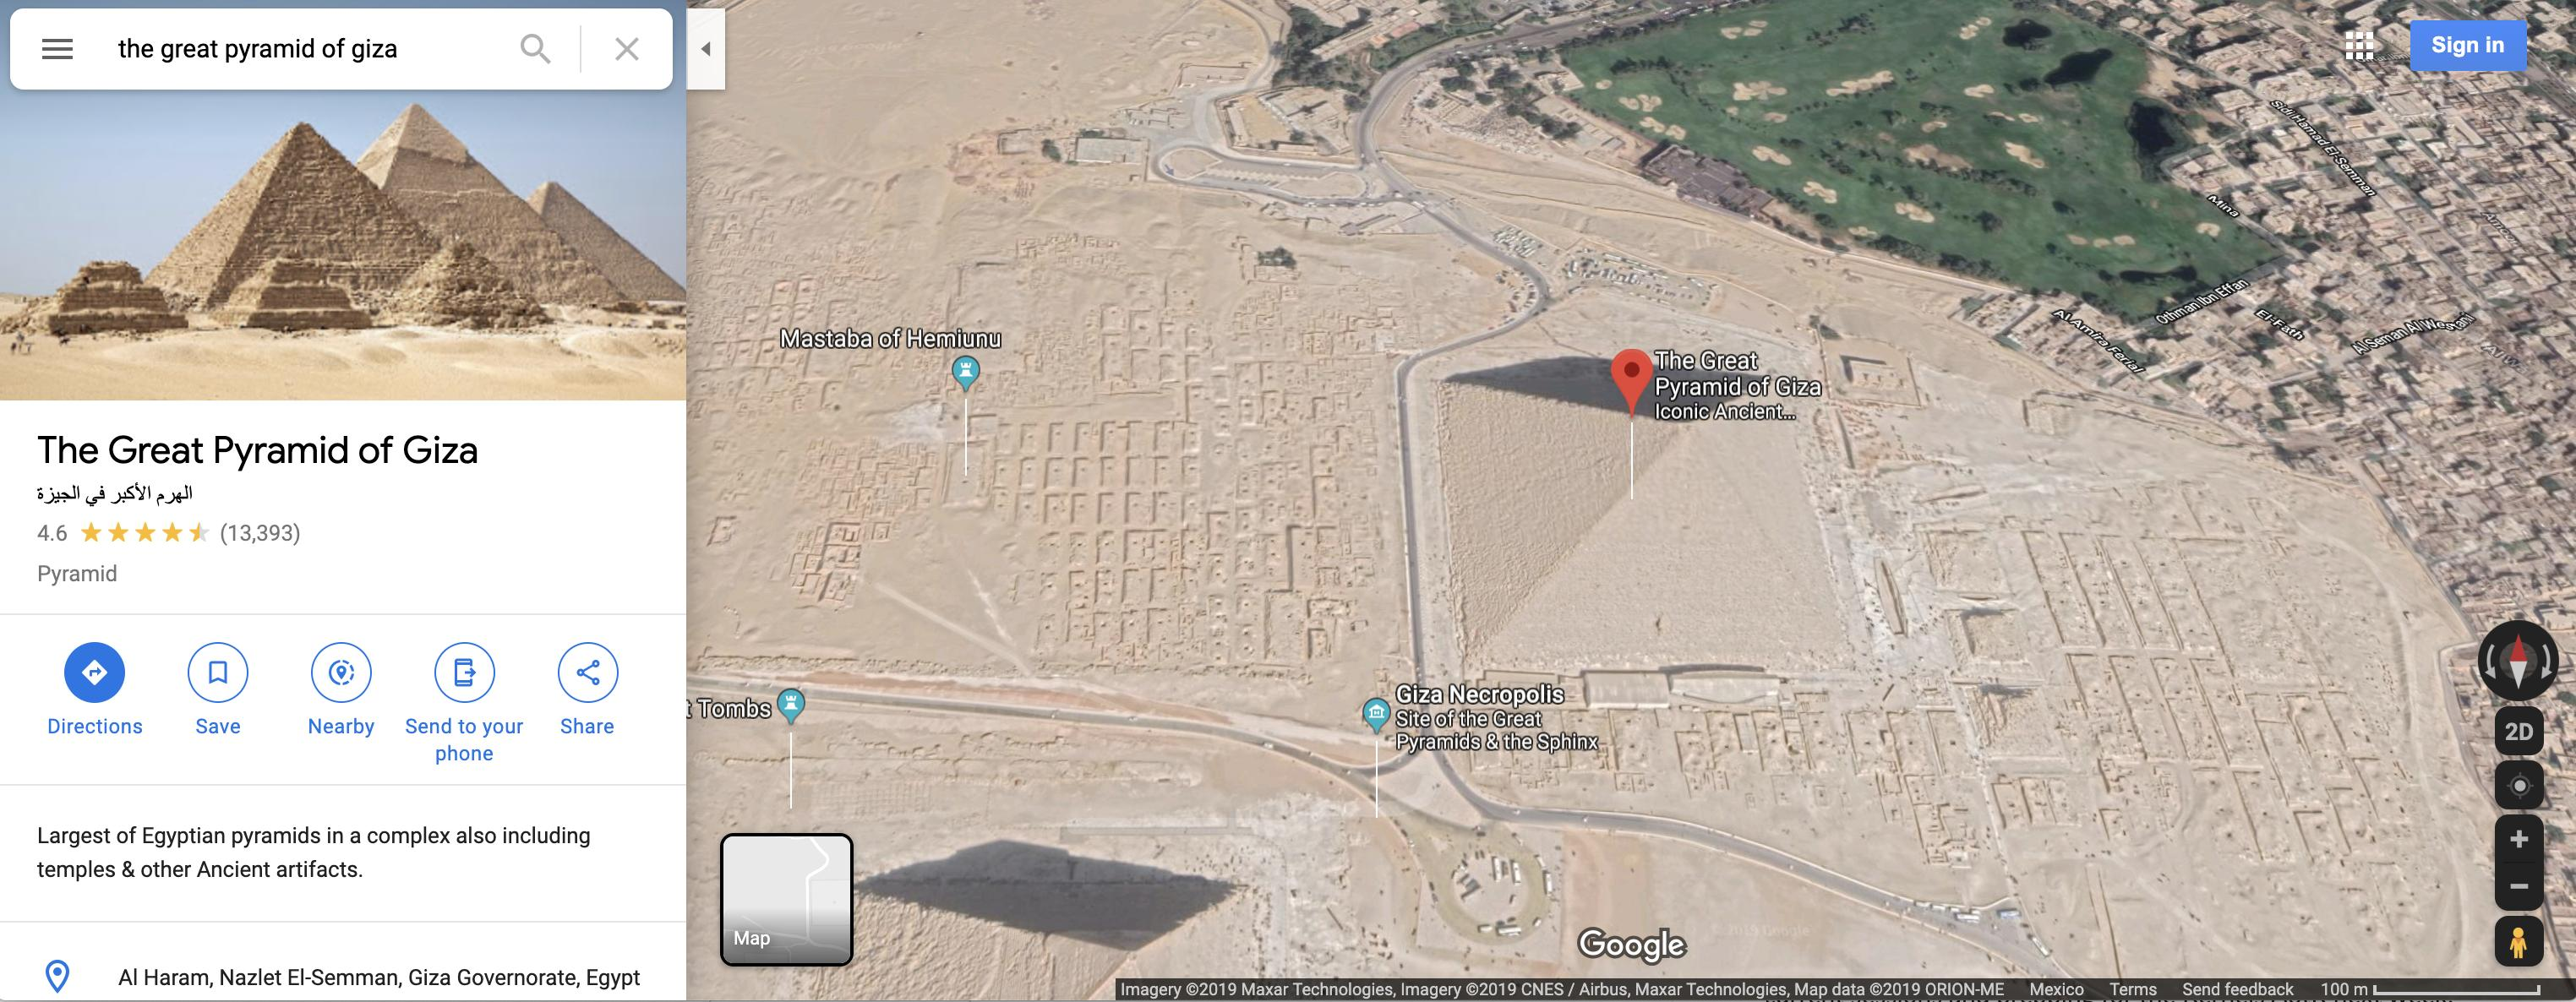



In [4]:
from geopy.geocoders import Nominatim

In [5]:
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("Pyramid of Khufu")

print(location.point)
print(location.address)

29 58m 44.976s N, 31 8m 3.17625s E
هرم خوفو, شارع ابو الهول السياحي, نزلة البطران, الجيزة, 12125, مصر


In [6]:
point = location.point
print("Latitude:", point.latitude)
print("Longitude:", point.longitude)

Latitude: 29.97916
Longitude: 31.134215625236113


In [9]:
universities = pd.read_csv("D:/archive (1)/top_universities.csv")
universities.head()

Name
0     University of Oxford
1  University of Cambridge
2  Imperial College London
3               ETH Zurich
4                      UCL

In [10]:
#좌표로 나오게 함

def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

universities[['Latitude', 'Longitude']] = universities.apply(lambda x: my_geocoder(x['Name']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(universities["Latitude"])) / len(universities)) * 100))

# Drop universities that were not successfully geocoded
universities = universities.loc[~np.isnan(universities["Latitude"])]
universities = gpd.GeoDataFrame(
    universities, geometry=gpd.points_from_xy(universities.Longitude, universities.Latitude))
universities.crs = {'init': 'epsg:4326'}
universities.head()

91.0% of addresses were geocoded!


Name   Latitude  Longitude                   geometry
0     University of Oxford  51.759037  -1.252430  POINT (-1.25243 51.75904)
1  University of Cambridge  52.200623   0.110474   POINT (0.11047 52.20062)
2  Imperial College London  51.498959  -0.175641  POINT (-0.17564 51.49896)
3               ETH Zurich  47.562772   7.580947   POINT (7.58095 47.56277)
4                      UCL  51.521785  -0.135151  POINT (-0.13515 51.52179)

In [11]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in universities.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Name']).add_to(m)

# Display the map
m

# Table joins
Now, we'll switch topics and think about how to combine data from different sources.

Attribute join
You already know how to use pd.DataFrame.join() to combine information from multiple DataFrames with a shared index. We refer to this way of joining data (by simpling matching values in the index) as an attribute join.

When performing an attribute join with a GeoDataFrame, it's best to use the gpd.GeoDataFrame.merge(). To illustrate this, we'll work with a GeoDataFrame europe_boundaries containing the boundaries for every country in Europe. The first five rows of this GeoDataFrame are printed below.

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world.loc[world.continent == 'Europe'].reset_index(drop=True)  #geometry dataframe이 아님

europe_stats = europe[["name", "pop_est", "gdp_md_est"]]
europe_boundaries = europe[["name", "geometry"]]  #이름과 geometry만 가지고 온거

In [13]:
europe_boundaries.head()  #국가별로 공간정보를 가지고 있음

name                                           geometry
0   Russia  MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...
1   Norway  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...
2   France  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...
3   Sweden  POLYGON ((11.02737 58.85615, 11.46827 59.43239...
4  Belarus  POLYGON ((28.17671 56.16913, 29.22951 55.91834...

In [14]:
europe_stats.head() #국가별로 수치별로 가지고 옴

name      pop_est  gdp_md_est
0   Russia  144373535.0     1699876
1   Norway    5347896.0      403336
2   France   67059887.0     2715518
3   Sweden   10285453.0      530883
4  Belarus    9466856.0       63080

In [15]:
# Use an attribute join to merge data about countries in Europe
#이름으로 합치기 
europe = europe_boundaries.merge(europe_stats, on="name")
europe.head()

name                                           geometry      pop_est   
0   Russia  MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...  144373535.0  \
1   Norway  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...    5347896.0   
2   France  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...   67059887.0   
3   Sweden  POLYGON ((11.02737 58.85615, 11.46827 59.43239...   10285453.0   
4  Belarus  POLYGON ((28.17671 56.16913, 29.22951 55.91834...    9466856.0   

   gdp_md_est  
0     1699876  
1      403336  
2     2715518  
3      530883  
4       63080

# Spatial join   두개의 공간 합치기
Another type of join is a spatial join. With a spatial join, we combine GeoDataFrames based on the spatial relationship between the objects in the "geometry" columns. For instance, we already have a GeoDataFrame universities containing geocoded addresses of European universities.

Then we can use a spatial join to match each university to its corresponding country. We do this with gpd.sjoin().

In [18]:
universities

Name   Latitude  Longitude   
0                University of Oxford  51.759037  -1.252430  \
1             University of Cambridge  52.200623   0.110474   
2             Imperial College London  51.498959  -0.175641   
3                          ETH Zurich  47.562772   7.580947   
4                                 UCL  51.521785  -0.135151   
..                                ...        ...        ...   
94          University of East Anglia  52.622251   1.241158   
95                 Aalborg University  57.015907   9.975308   
97               University of Bergen  60.368876   5.351112   
98  Lomonosov Moscow State University  55.705541  37.536060   
99              University of Antwerp  51.184386   4.419939   

                     geometry  
0   POINT (-1.25243 51.75904)  
1    POINT (0.11047 52.20062)  
2   POINT (-0.17564 51.49896)  
3    POINT (7.58095 47.56277)  
4   POINT (-0.13515 51.52179)  
..                        ...  
94   POINT (1.24116 52.62225)  
95   POINT (9.97531 57.01591)  
97   POINT (5.35111 60.36888)  
98  POINT (37.53606 55.70554)  
99   POINT (4.41994 51.18439)  

[90 rows x 4 columns]

In [23]:
# Use spatial join to match universities to countries in Europe
#왼쪽이 기준 / 오른쪽이 붙음 
european_universities = gpd.sjoin(universities, europe)

# Investigate the result
print("We located {} universities.".format(len(universities)))
print("We located {} universities.".format(len(universities))) #{} 안에 universities의 len이 들어감
# f-string으로 변경할수 있음
#print(f"We located {len(universities)} universities.")

print("Only {} of the universities were located in Europe (in {} different countries).".format(
  len(european_universities), len(european_universities.name.unique())))

#너무 길면 \ 사용하면 됨

#f - string 사용 방법
#print(f"Only {european_universities} of the universities were located in Europe \
#      (in {european_universities.name.unique()} different countries).")

european_universities.head()

We located 90 universities.
Only                                                 Name   Latitude  Longitude   
0                               University of Oxford  51.759037  -1.252430  \
1                            University of Cambridge  52.200623   0.110474   
2                            Imperial College London  51.498959  -0.175641   
4                                                UCL  51.521785  -0.135151   
5   London School of Economics and Political Science  51.514211  -0.116808   
..                                               ...        ...        ...   
97                              University of Bergen  60.368876   5.351112   
63                              University of Vienna  48.213128  16.360686   
71                        Scuola Superiore Sant’Anna  43.720608  10.402644   
75                  Scuola Normale Superiore di Pisa  43.719669  10.400433   
98                 Lomonosov Moscow State University  55.705541  37.536060   

                     geometry 

Name   Latitude  Longitude   
0                              University of Oxford  51.759037  -1.252430  \
1                           University of Cambridge  52.200623   0.110474   
2                           Imperial College London  51.498959  -0.175641   
4                                               UCL  51.521785  -0.135151   
5  London School of Economics and Political Science  51.514211  -0.116808   

                    geometry  index_right            name     pop_est   
0  POINT (-1.25243 51.75904)           28  United Kingdom  66834405.0  \
1   POINT (0.11047 52.20062)           28  United Kingdom  66834405.0   
2  POINT (-0.17564 51.49896)           28  United Kingdom  66834405.0   
4  POINT (-0.13515 51.52179)           28  United Kingdom  66834405.0   
5  POINT (-0.11681 51.51421)           28  United Kingdom  66834405.0   

   gdp_md_est  
0     2829108  
1     2829108  
2     2829108  
4     2829108  
5     2829108